# Missing and Spurius Interactions in Complex Networks

Student: Joan Verguizas I Moliner

Course: Information Theory & Inference

Master's Degree: Physics of Data



In [1]:
system("apt-get install -y libgmp3-dev libmpfr-dev")
install.packages("igraph")
install.packages("igraphdata")
install.packages("gridExtra")
install.packages("Rmpfr")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘gmp’




In [2]:
library(igraph)
library(igraphdata)
library(ggplot2)
library(gridExtra)
library(Rmpfr)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: gmp


Attaching package: ‘gmp’


The following objects are masked from ‘package:base’:

    %*%, apply, crossprod, matrix, tcrossprod


C code of R package 'Rmpfr': GMP using 64 bits per limb



Attaching package: ‘Rmpfr’


The following object is masked from ‘package:gmp’:

    outer


The following objects are masked from ‘package:stats’:

    dbinom, dgamma, dnbinom, dnorm, dpois, dt, pnorm


The following objects are masked from ‘package:base’:

    cbind, pmax, pmin, rbind




## Karate Class Network

The Karate Club network is a famous social network dataset studied by Wayne Zachary in 1977. It represents the social interactions between 34 members of a karate club at a U.S. university during a period of conflict within the club.

There are 34 nodes, each representing a member of the karate club and 78 edges, representing the friendships or social interactions between pairs of members. An edge exists between two members if they interacted outside the club.

### Initialization of the Network

We initialize the network by placing each of the N nodes in a group, which we choose with uniform probability from a set of N possible groups.


In [3]:
# load karate data

data("karate")

# eliminate all attributes to enhance computation time and create one for the communities

network_initialization <- function(network, number_communities){

  vertex_attributes <- vertex_attr_names(network)
  if (length(vertex_attributes)) {
    for (attr in vertex_attributes){
      network <- delete_vertex_attr(network, attr)
    }
  }

  graph_attributes <- graph_attr_names(network)
  if (length(graph_attributes)) {
    for (attr in graph_attributes){
      network <- delete_graph_attr(network, attr)
    }
  }

  edge_attributes <- edge_attr_names(network)
  if(length(edge_attributes)) {
    for (attr in edge_attributes){
      network <- delete_edge_attr(network, attr)
    }
  }

  N <- length(network)
  initial_partition <- sample(seq(number_communities), N, replace=TRUE)
  V(network)$partition <- initial_partition

  return(network)
}

karate <- network_initialization(karate, number_communities = length(karate))

This graph was created by an old(er) igraph version.
  Call upgrade_graph() on it to use with the current igraph version
  For now we convert it on the fly...



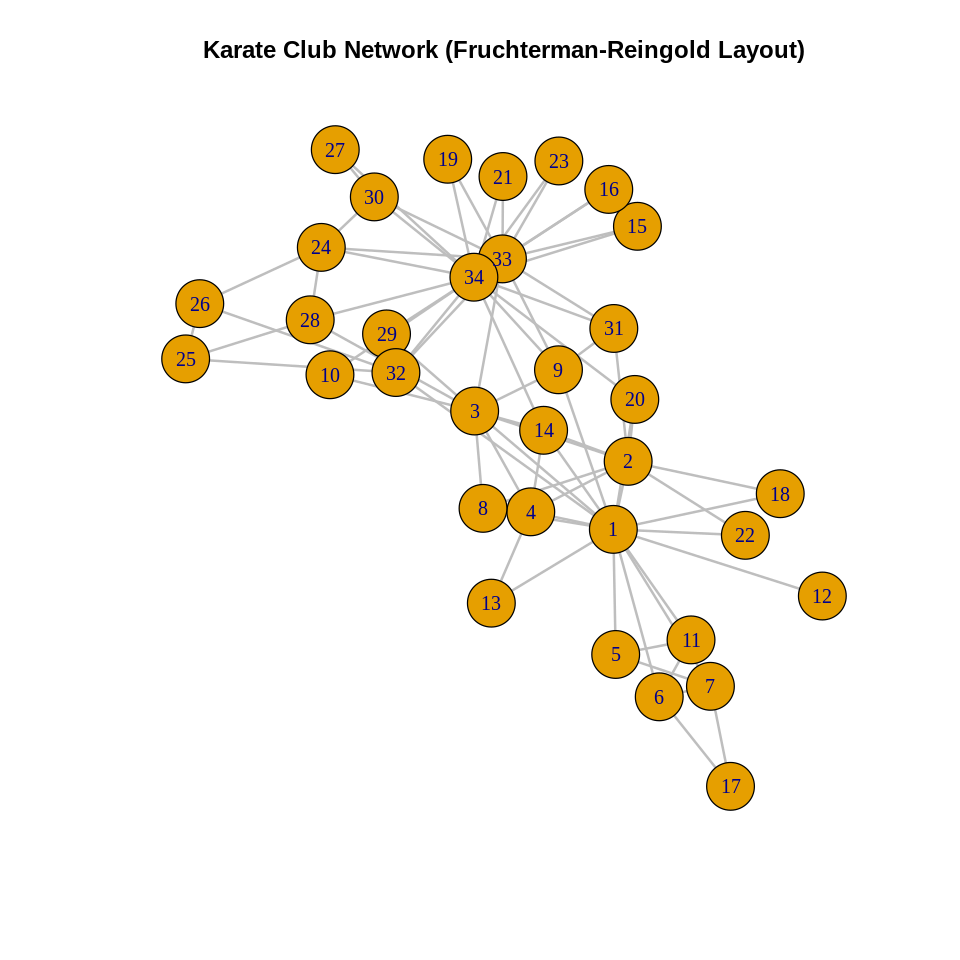

In [4]:
# plot of the network

options(repr.plot.width=8, repr.plot.height=8)

plot(karate,
     layout = layout_with_fr,  # Fruchterman-Reingold layout
     vertex.size = 15,
     edge.color = "gray",
     edge.width = 2,
     main = "Karate Club Network (Fruchterman-Reingold Layout)")

### Sampling of the Partitions

The reliability of an individual link between nodes i and j, expresses the probability that a link truly exists given the observed network. The formula of $R_{ij}^L$ is expressed as:

$$ R_{ij}^L = \frac{1}{Z} \sum_{P \in \mathcal{P}} \left( \frac{ l_{\sigma_i \sigma_j}^O + 1}{ r_{\sigma_i \sigma_j} + 2 } \right) \exp{ [-H(P)]  }   $$

Where the functions $H(P)$ and $Z$ are:

$$  H(P) = \sum_{P \in \mathcal{P}} \left[ \ln{(r_{\alpha \beta} + 1)} + \ln{ \binom{r_{\alpha \beta}}{l^O_{\alpha \beta}} }   \right] \qquad Z = \sum_{P \in \mathcal{P}} \exp{[-H(P)]}  $$

Since it is not possible to sum over all partitions even for small networks, we can use a Metropolis algorithm to correctly sample relevant partitions (that is, partitions that significantly contribute to the sum) and obtain estimates for the link reliability.

During the Metropolis algorithm at each step we select a random node and attempt to move it to a randomly selected group. This in an ergodic exploration of the space of possible partitions. To decide whether we accept the move, we calculate the change $\Delta H$, if $\Delta H \leq 0$, the change is automatically accepted; otherwise, the change is accepted with probability $\exp{(−\Delta H)}$. We have considered $10^4$ iterations.

In [5]:
H_P <- function(number_communities, network) {

  H <- 0

  A <- as_adj(network, sparse = FALSE)

  community_nodes <- lapply(1:number_communities, function(c) which(V(network)$partition == c))

  for (beta in 1:number_communities) {
    nodes_beta <- community_nodes[[beta]]

    for (alpha in beta:number_communities) {
      nodes_alpha <- community_nodes[[alpha]]

      if (alpha == beta) {

        num_nodes_alpha <- length(nodes_alpha)
        rmax <- (num_nodes_alpha * (num_nodes_alpha - 1)) / 2
        l <- sum(A[nodes_alpha, nodes_alpha]) / 2  # divide by 2 to avoid double-counting

      } else {
        num_nodes_alpha <- length(nodes_alpha)
        num_nodes_beta <- length(nodes_beta)
        rmax <- (num_nodes_alpha * num_nodes_beta)
        l <- sum(A[nodes_alpha, nodes_beta])
      }

      H <- H + log(1 + rmax) + lchoose(n = rmax, k = l)
    }
  }

  return(H)
}


In [6]:
metropolis <- function(network, epochs, number_communities) {

  H <- H_P(number_communities = number_communities, network = network)

  H_result <- numeric(epochs)
  partitions <- vector("list", epochs)

  for (epoch in 1:epochs) {

    random_node <- sample(V(network), 1)
    current_partition <- V(network)$partition[random_node]

    partition_candidate <- setdiff(1:number_communities, current_partition)

    if (length(partition_candidate) > 1){
      partition_candidate <- sample(partition_candidate, 1)
    }

    V(network)$partition[random_node] <- partition_candidate

    H_candidate <- H_P(number_communities = number_communities, network = network)

    delta_H <- H_candidate - H

    # Metropolis acceptance criterion
    if (delta_H < 0 || runif(1) < exp(-delta_H)) {
      H <- H_candidate
    } else {
      V(network)$partition[random_node] <- current_partition
    }

    H_result[epoch] <- H
    partitions[[epoch]] <- V(network)$partition
  }

  return(list(H = H_result, partitions = partitions))
}


In [7]:

epochs <- 10000
number_communities <- length(karate)

part_samples <- metropolis(karate, epochs=epochs, number_communities = number_communities)


After computing the partitions with their corresponding energy vale $H(P)$, we can represent how this values is minimized during the Metropolis algorithm until reaching a steady state in which fluctuates among a set of optimal partitions. The plot is show above:

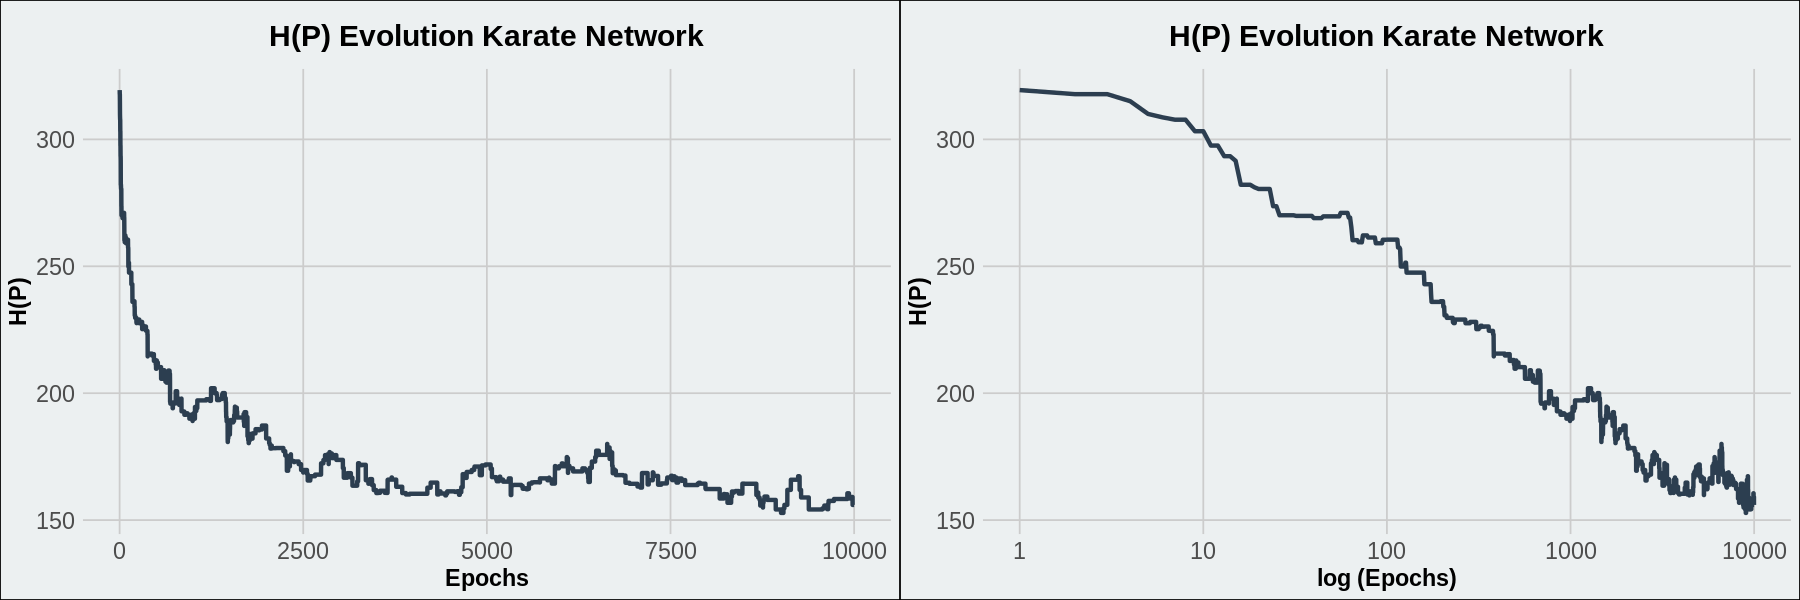

In [8]:
H_data <- data.frame(epoch=1:10000, H=part_samples$H)
options(repr.plot.width=15, repr.plot.height=5)

plotH <- function(data, title, log_axis=FALSE, x_axis){

  p <- ggplot(data, aes(x=epoch, y=H)) +
  geom_line(color="#2C3E50", linewidth=1.25) +
  theme_minimal(base_family = "Helvetica") +
  theme(axis.title = element_text(size=14, face="bold"),
        axis.text = element_text(size=14),
        plot.title = element_text(size=18, face="bold", hjust=0.5, margin = margin(b=10, t=10)),
        plot.background = element_rect(fill="#ECF0F1"),
        panel.grid.major = element_line(color="gray80"),
        panel.grid.minor = element_blank()) +
  labs(x=x_axis, y="H(P)", title=title) +
  coord_cartesian(clip = 'off')

  if(log_axis == TRUE){
    p <- p + scale_x_log10()
  }
  return(p)
}

p1 <- plotH(H_data, title = "H(P) Evolution Karate Network", x_axis="Epochs")
p2 <- plotH(H_data, title = "H(P) Evolution Karate Network", log_axis = TRUE, x_axis="log (Epochs)")

grid.arrange(p1, p2, ncol=2)

### Creation of Observed Networks

To evaluate our approach we create a set of hypothetical observations of our network $A^O$ by adding or removing random connections from the true network $A^T$ and see if the reliability metric is able to differentiate between a true or false link and a true or false missing connection.

In [9]:
missing_network <- function(network, p) {

  N <- round(length(E(network))*p)
  e <- sample(E(network), size = N)

  network <- delete_edges(network, e)

  return(network)
}

spurious_network <- function(network, p) {

  N = round(length(E(network))*p)
  network_size = length(E(network))
  while (length(E(network)) < N + network_size) {
    endpoints <- sample(as.numeric(V(network)), 2, replace = FALSE)
      if (! are_adjacent(network, endpoints[1], endpoints[2])) {
        network <- add_edges(network, endpoints)
      }
  }

  return(network)
}


In [10]:
reliability_spurious_optimized <- function(network_spurious, epochs, partitions) {

  H_values <- mpfr(partitions$H, 32)

  num_edges <- length(E(network_spurious))
  z <- sum(exp(-H_values))
  exp_neg_H <- exp(-H_values)

  A <- as_adj(network_spurious, sparse = FALSE)

  edge_list <- which(A != 0, arr.ind = TRUE)

  edge_list <- edge_list[edge_list[,1] < edge_list[,2], ]

  rel_ij <- numeric(nrow(edge_list))

  for (edge_idx in 1:nrow(edge_list)){

    node_i <- as.numeric(edge_list[edge_idx, 1])
    node_j <- as.numeric(edge_list[edge_idx, 2])

    rel <- 0

    for (epoch in 1:epochs) {

      partition <- partitions$partitions[[epoch]]
      i_part <- partition[node_i]
      j_part <- partition[node_j]

      nodes_i <- which(partition == i_part)
      nodes_j <- which(partition == j_part)

      if (i_part == j_part) {

        r <- (length(nodes_i) * (length(nodes_i) - 1)) / 2
        l <- sum(A[nodes_i, nodes_i]) / 2

      } else {
        r <- length(nodes_i) * length(nodes_j)
        l <- sum(A[nodes_i, nodes_j])  # Count edges between communities
      }

      rel <- rel + ((l + 1) / (r + 2)) * exp_neg_H[epoch]

    }

    rel <- rel / z

    rel_ij[edge_idx] <- as.numeric(rel)
  }

  return(rel_ij)
}


To evaluate the ability to identify spurious interactions by adding random links to the true network, we will calculate the reliability of all links in the observed networks $A^O$. And then compute the probability that a false positive ($A_{ij}^O = 1$ and $A_{ij}^T = 0$) has lower reliability than a true positive ($A_{ij}^O = 1$ and $A_{ij}^T = 1$).

In [11]:
row_to_string <- function(x) {
  apply(x, 1, function(row) paste(row, collapse = ","))
}


accuracy_spurious <- function(true_network, observed_network, rel_values) {

  obs_adj <- as_adj(observed_network, sparse = FALSE)
  obs_edges <- which(obs_adj != 0, arr.ind = TRUE)
  obs_edges <- obs_edges[obs_edges[,1] < obs_edges[,2], ]

  true_adj <- as_adj(true_network, sparse=FALSE)
  diff <- obs_adj - true_adj
  true_edges <- which(diff > 0, arr.ind = TRUE)
  true_edges <- true_edges[true_edges[,1] < true_edges[,2], ]

  obs_pairs <- row_to_string(obs_edges)
  true_pairs <- row_to_string(true_edges)

  indices <- match(obs_pairs, true_pairs)
  false_pos_indices <- which(!is.na(indices))

  false_pos <- rel[false_pos_indices]
  true_pos <- rel[-false_pos_indices]

  accuracy_sum <- 0

  for (fp in false_pos) {
    accuracy_sum <- accuracy_sum + sum(fp < true_pos) / length(true_pos)
  }

  accuracy <- accuracy_sum / length(false_pos)
  return(accuracy)
}



In [25]:
p <- seq(from = 0.1, to = 0.9, by = 0.1)
accuracy_seq <- list()

iter <- 25
epochs <- 10000
number_communities <- length(karate)


for (i in 1:iter){
  acc <- c()
  for (prob in p) {
    observed_spurious <- spurious_network(network = karate, p = prob)
    part_samples <- metropolis(observed_spurious, epochs=epochs, number_communities = number_communities)

    rel <- reliability_spurious_optimized(observed_spurious, epochs = epochs, part_samples)
    accuracy <- accuracy_spurious(true_network = karate, observed_network = observed_spurious, rel_values = rel)
    acc <- c(acc, accuracy)
  }
  accuracy_seq[[i]] <- acc
}


In [62]:
acc_matrix <- do.call(rbind, accuracy_seq)

karate_spurious <- data.frame(p=seq(0.1, 0.9, 0.1), accuracy_mean = colMeans(acc_matrix), accuracy_std = apply(acc_matrix, 2, sd))

write.csv(karate_spurious, file = "./Data/karate_spurious.csv", row.names=FALSE)



In [27]:
karate_spurious <- read.csv("./Data/karate_spurious.csv"); karate_spurious

p,accuracy_mean,accuracy_std
<dbl>,<dbl>,<dbl>
0.1,0.8445513,0.06558939
0.2,0.8468269,0.05372957
0.3,0.8315719,0.04559836
0.4,0.8247974,0.04301073
0.5,0.8008021,0.05225459
0.6,0.7932788,0.03259776
0.7,0.7625361,0.05212178
0.8,0.7486600,0.04711874
0.9,0.7560513,0.03930725


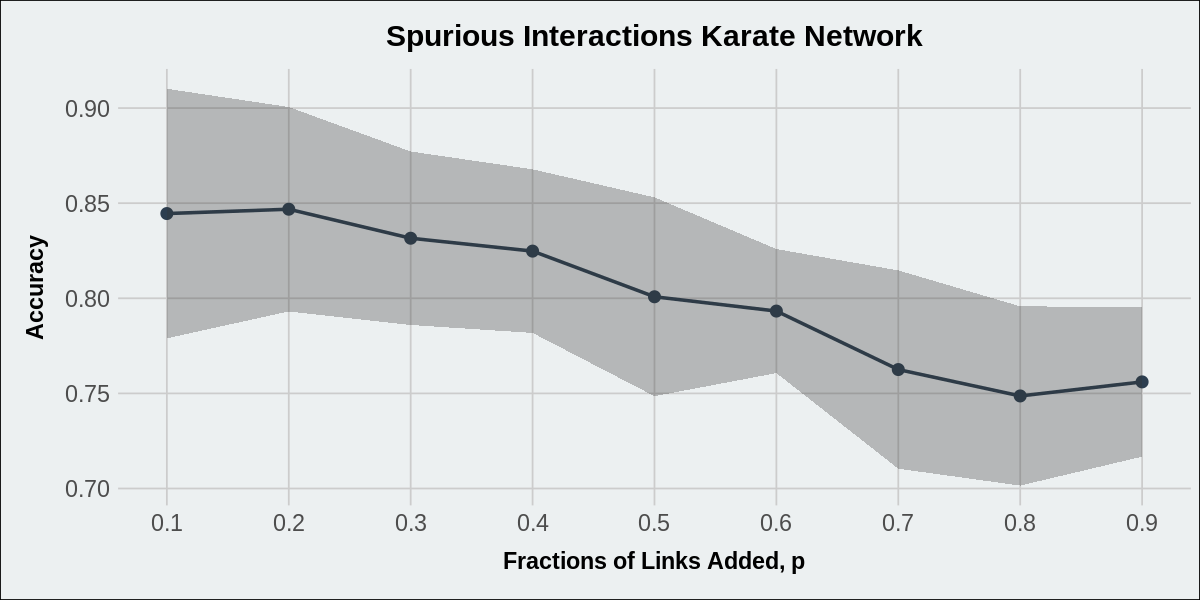

In [15]:
options(repr.plot.width=10, repr.plot.height=5)

accuracy_plot <- function(data, title, xlabel) {
  ggplot(data, aes(x = p, y = accuracy_mean)) +
    geom_line(color = "#2C3E50", linewidth = 1) +
    geom_point(size = 3, color = "#2C3E50") +
    geom_ribbon(aes(ymin = accuracy_mean - accuracy_std, ymax = accuracy_mean + accuracy_std),         # Shaded region for standard deviation
              fill = "#333", alpha = 0.3) +
    labs(title = title,
       x = xlabel,
       y = "Accuracy") +
    theme_minimal() +
    scale_x_continuous(breaks = seq(0, 1, by = 0.1)) +
    theme(axis.title = element_text(size=14, face="bold"),
        axis.title.x = element_text(margin = margin(t = 10, b = 10)),
        axis.title.y = element_text(margin = margin(r = 10, l = 10)),
        axis.text = element_text(size=14),
        plot.title = element_text(size=18, face="bold", hjust=0.5, margin = margin(b=10, t=10)),
        plot.background = element_rect(fill="#ECF0F1"),
        panel.grid.major = element_line(color="gray80"),
        panel.grid.minor = element_blank())
}

accuracy_plot(karate_spurious, title="Spurious Interactions Karate Network",
xlabel="Fractions of Links Added, p")


### Missing Interactions

We will proceed similarly for missing interactions, where we will create a set of hypothetical observations of our network $A^O$ by removing random connections from the true network $A^T$. Later, we proceed by calculating the reliability of all links in the observed networks $A^O$. And then compute the probability that a false negative ($A_{ij}^O = 0$ and $A_{ij}^T = 1$) has bigger reliability than a true negative ($A_{ij}^O = 0$ and $A_{ij}^T = 0$).

In [16]:
reliability_missing_optimized <- function(network_missing, epochs, partitions) {

  num_edges <- length(E(network_missing))
  z <- sum(exp(-partitions$H))
  exp_neg_H <- exp(-partitions$H)



  A <- as_adj(network_missing, sparse = FALSE)

  non_edge_list <- which(A == 0, arr.ind = TRUE)

  non_edge_list <- non_edge_list[non_edge_list[,1] < non_edge_list[,2], ]

  rel_ij <- numeric(nrow(non_edge_list))

  for (edge_idx in 1:nrow(non_edge_list)){

    node_i <- as.numeric(non_edge_list[edge_idx, 1])
    node_j <- as.numeric(non_edge_list[edge_idx, 2])

    rel <- 0

    for (epoch in 1:epochs) {

      partition <- partitions$partitions[[epoch]]
      i_part <- partition[node_i]
      j_part <- partition[node_j]

      nodes_i <- which(partition == i_part)
      nodes_j <- which(partition == j_part)

      if (i_part == j_part) {

        r <- (length(nodes_i) * (length(nodes_i) - 1)) / 2
        l <- sum(A[nodes_i, nodes_i]) / 2

      } else {
        r <- length(nodes_i) * length(nodes_j)
        l <- sum(A[nodes_i, nodes_j])  # Count edges between communities
      }

      rel <- rel + ((l + 1) / (r + 2)) * exp_neg_H[epoch]
    }


    rel <- rel / z

    rel_ij[edge_idx] <- rel


  }

  return(rel_ij)
}


In [17]:
accuracy_missing <- function(true_network, observed_network, rel_values) {

  obs_adj <- as_adj(observed_network, sparse = FALSE)
  obs_non_edges <- which(obs_adj == 0, arr.ind = TRUE)
  obs_non_edges <- obs_non_edges[obs_non_edges[,1] < obs_non_edges[,2], ]

  true_adj <- as_adj(true_network, sparse=FALSE)
  diff <- true_adj - obs_adj
  false_non_edges <- which(diff > 0, arr.ind = TRUE)
  false_non_edges <- false_non_edges[false_non_edges[,1] < false_non_edges[,2], ]

  obs_pairs <- row_to_string(obs_non_edges)
  false_pairs <- row_to_string(false_non_edges)

  indices <- match(obs_pairs, false_pairs)
  false_neg_indices <- which(!is.na(indices))

  true_neg <- rel[-false_neg_indices]
  false_neg <- rel[false_neg_indices]

  accuracy_sum <- 0

  for (fn in false_neg) {
    accuracy_sum <- accuracy_sum + sum(fn > true_neg) / length(true_neg)
  }

  accuracy <- accuracy_sum / length(false_neg)
  return(accuracy)
}



In [18]:
p <- seq(from = 0.1, to = 0.9, by = 0.1)

accuracy_seq <- list()

iter <- 10
epochs <- 10000
number_communities <- length(karate)


for (i in 1:iter){
  acc <- c()
  for (prob in p) {
    observed_missing <- missing_network(network = karate, p = prob)
    part_samples <- metropolis(observed_missing, epochs=epochs, number_communities = number_communities)

    rel <- reliability_missing_optimized(observed_missing, epochs = epochs, part_samples)
    accuracy <- accuracy_missing(true_network = karate, observed_network = observed_missing,
     rel_values = rel)
    acc <- c(acc, accuracy)
  }
  accuracy_seq[[i]] <- acc
}


In [68]:
acc_matrix <- do.call(rbind, accuracy_seq)

karate_missing <- data.frame(p=seq(0.1, 0.9, 0.1), accuracy_mean = colMeans(acc_matrix), accuracy_std = apply(acc_matrix, 2, sd))

write.csv(karate_missing, file = "./Data/karate_missing.csv", row.names=FALSE)



In [28]:
karate_missing <- read.csv("./Data/karate_missing.csv"); karate_missing

p,accuracy_mean,accuracy_std
<dbl>,<dbl>,<dbl>
0.1,0.8961698,0.07466891
0.2,0.8409420,0.04202837
0.3,0.8079305,0.04455104
0.4,0.7558405,0.04266648
0.5,0.7650634,0.05853396
0.6,0.7394080,0.04410903
0.7,0.6683682,0.07366252
0.8,0.6147966,0.05921891
0.9,0.5740846,0.06580600


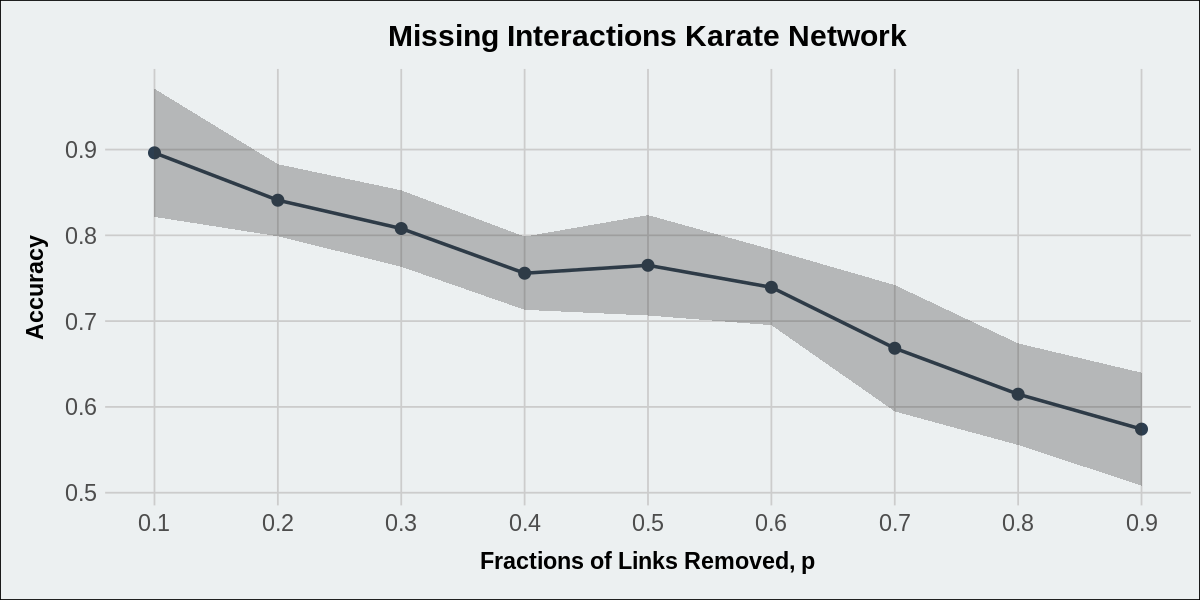

In [19]:
accuracy_plot(karate_missing, title="Missing Interactions Karate Network",
xlabel="Fractions of Links Removed, p")

## Dolphin Social Network

The Dolphin Social Network studied by David Lusseau et.a. represents the social interactions among a population of bottlenose dolphins living in Doubtful Sound, New Zealand.

The network consists of 62 nodes, each representing an individual dolphin and 159 edges, where an edge between two dolphins represents a significant social association. These associations were determined based on observed interactions, such as swimming together or being in close proximity.

The network naturally divides into multiple communities, which correspond to groups of dolphins that associate more frequently with each other than with those outside their group.

In [20]:
dolphins <- read_graph(file='https://networkdata.ics.uci.edu/data/dolphins/dolphins.gml', format='gml')

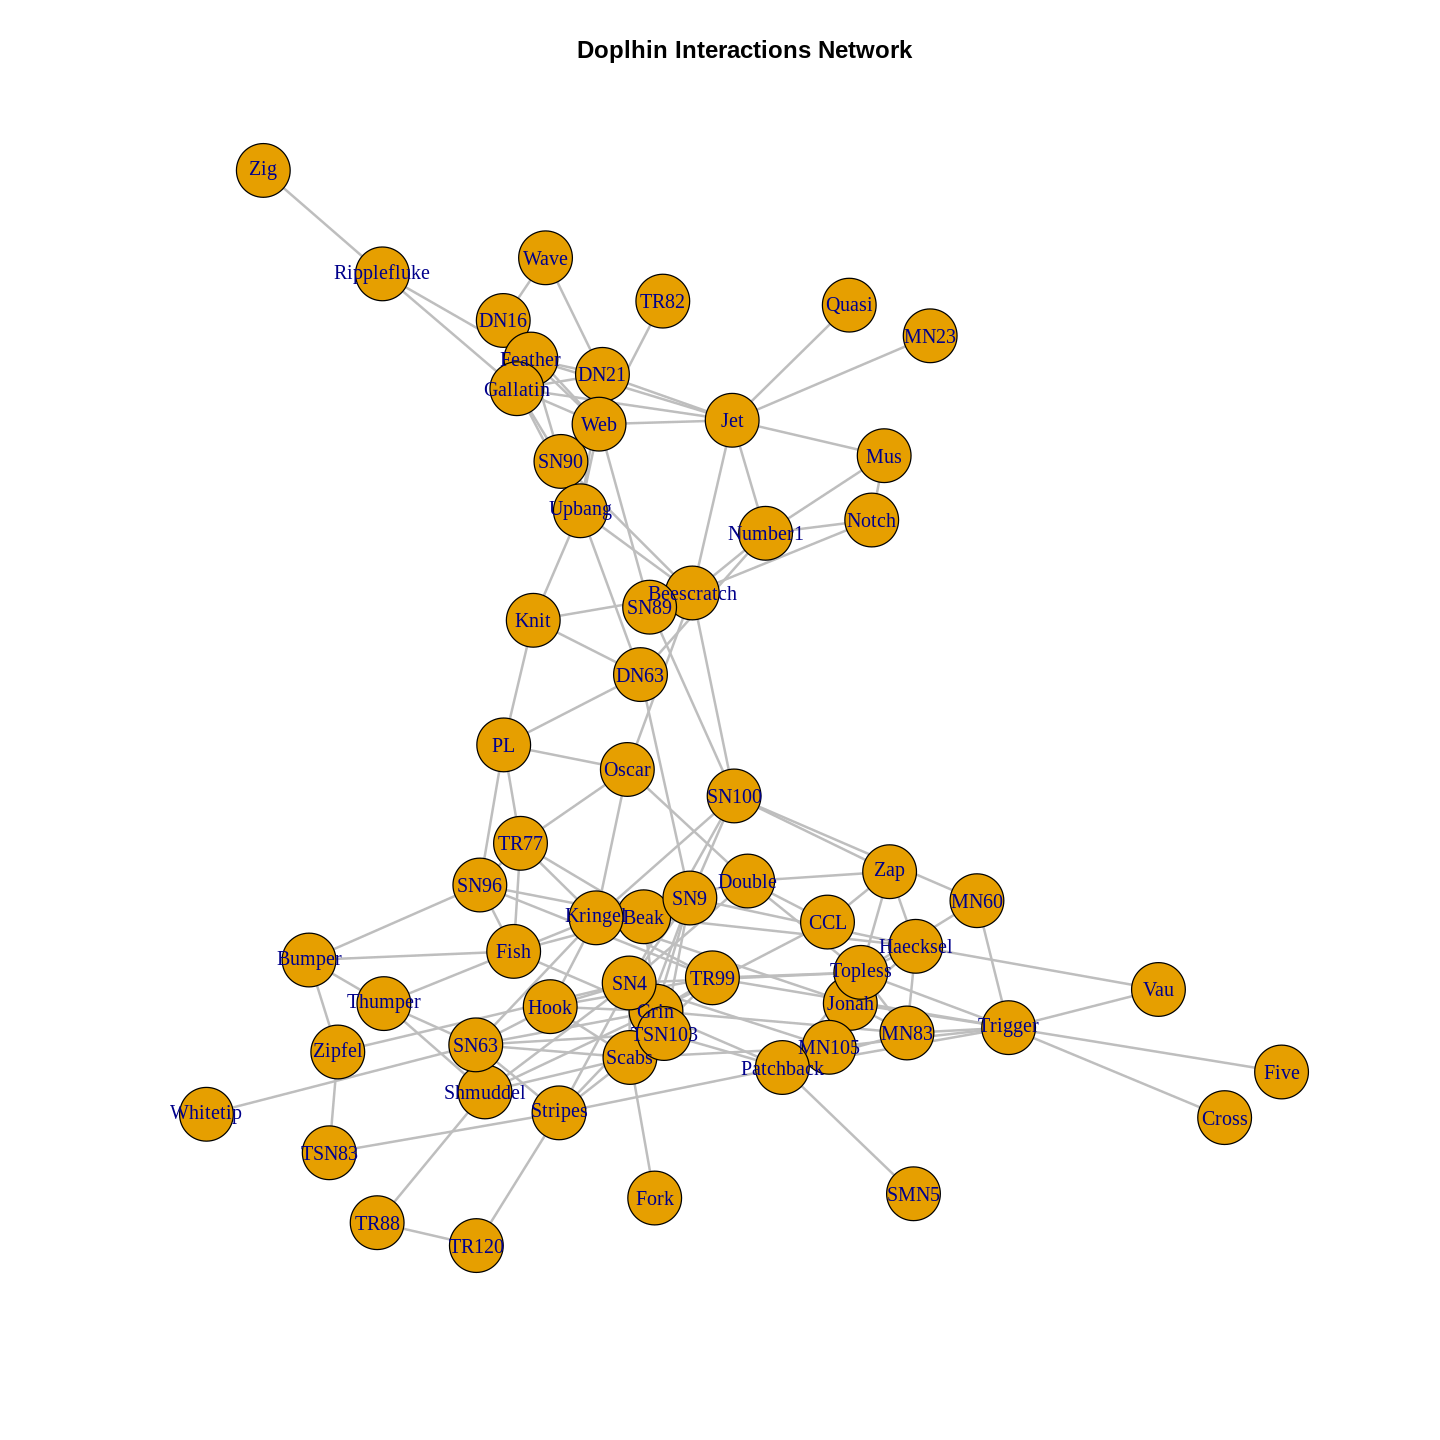

In [21]:
options(repr.plot.width=12, repr.plot.height=12)

plot(dolphins,
     layout = layout_with_fr,  # Fruchterman-Reingold layout
     vertex.size = 10,
     edge.color = "gray",
     edge.width = 2,
     main = "Doplhin Interactions Network")

In [22]:
dolphins <- network_initialization(dolphins, number_communities = length(dolphins))

In [23]:
epochs <- 10000
number_communities <- length(dolphins)

part_samples <- metropolis(dolphins, epochs=epochs, number_communities = number_communities)


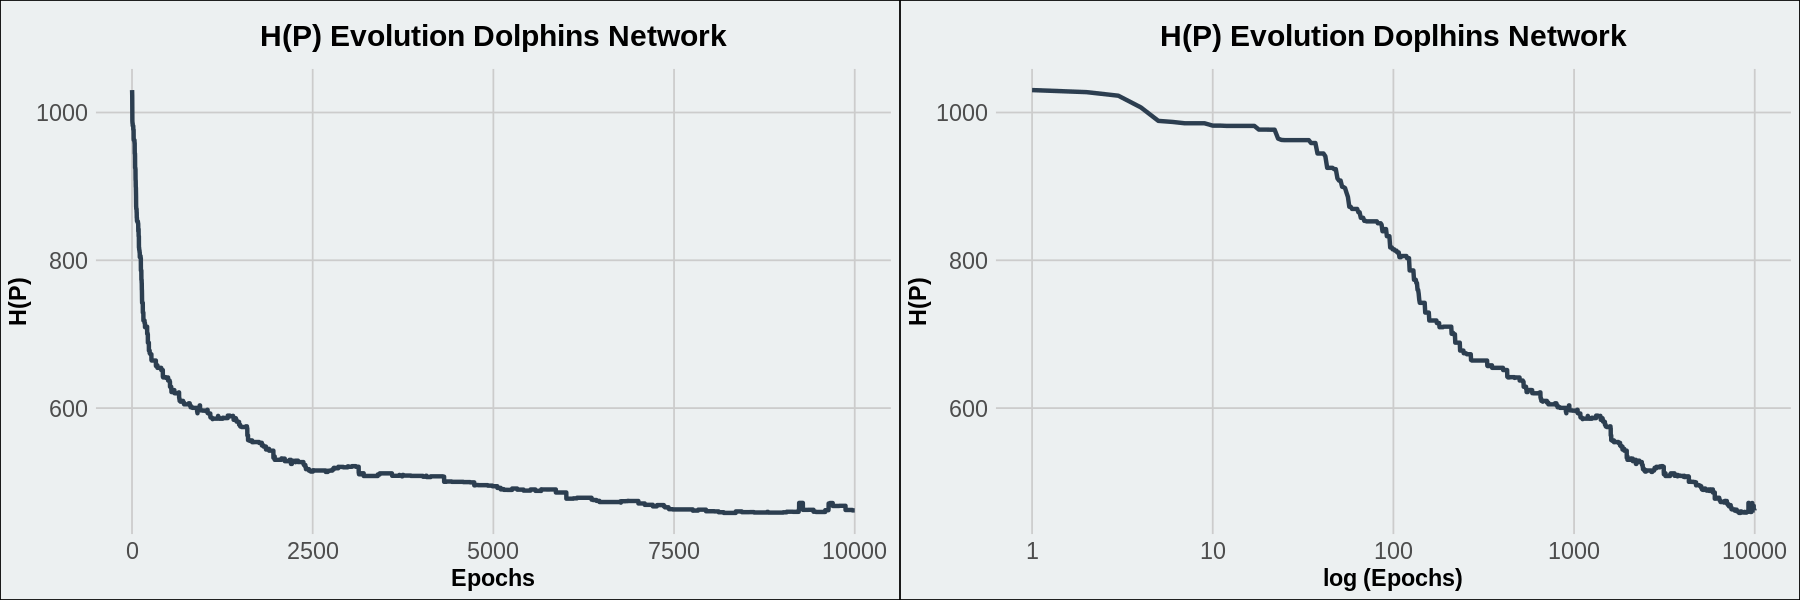

In [24]:
options(repr.plot.width=15, repr.plot.height=5)
H_data <- data.frame(epoch=1:10000, H=part_samples$H)

p1 <- plotH(H_data, title = "H(P) Evolution Dolphins Network", x_axis="Epochs")
p2 <- plotH(H_data, title = "H(P) Evolution Doplhins Network", log_axis = TRUE, x_axis="log (Epochs)")

grid.arrange(p1, p2, ncol=2)

In [24]:

p <- seq(from = 0.1, to = 0.9, by = 0.1)
accuracy_seq <- list()

iter <- 25
epochs <- 10000
number_communities <- length(dolphins)

for (i in 1:iter){
  acc <- c()
  for (prob in p) {
    observed_spurious <- spurious_network(network = dolphins, p = prob)
    part_samples <- metropolis(observed_spurious, epochs=epochs, number_communities = number_communities)

    rel <- reliability_spurious_optimized(observed_spurious, epochs = epochs, part_samples)
    accuracy <- accuracy_spurious(true_network = dolphins, observed_network = observed_spurious, rel_values = rel)
    acc <- c(acc, accuracy)
  }
  accuracy_seq[[i]] <- acc
}




In [25]:
acc_matrix <- do.call(rbind, accuracy_seq)

dolphins_spurious <- data.frame(p=seq(0.1, 0.9, 0.1),
accuracy_mean = colMeans(acc_matrix),
accuracy_std = apply(acc_matrix, 2, sd))

write.csv(dolphins_spurious, file = "./Data/dolphins_spurious.csv", row.names=FALSE)



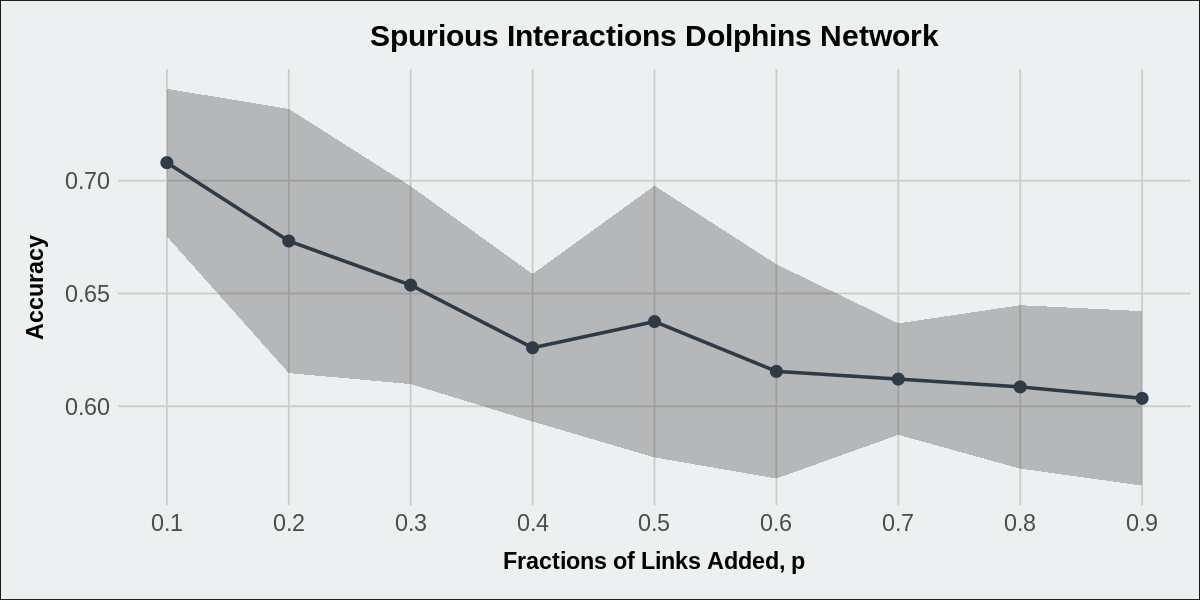

In [29]:
options(repr.plot.width=10, repr.plot.height=5)

dolphins_spurious <- read.csv("./Data/dolphins_spurious.csv")

accuracy_plot(dolphins_spurious, title="Spurious Interactions Dolphins Network",
xlabel="Fractions of Links Added, p")

### Missing Interactions

In [24]:
p <- seq(from = 0.1, to = 0.9, by = 0.1)

accuracy_seq <- list()

iter <- 10
epochs <- 10000
number_communities <- length(dolphins)

for (i in 1:iter){
  acc <- c()
  for (prob in p) {
    observed_missing <- missing_network(network = dolphins, p = prob)
    part_samples <- metropolis(observed_missing, epochs=epochs, number_communities = number_communities)

    rel <- reliability_missing_optimized(observed_missing, epochs = epochs, part_samples)
    accuracy <- accuracy_missing(true_network = dolphins, observed_network = observed_missing,
     rel_values = rel)
    acc <- c(acc, accuracy)
  }
  accuracy_seq[[i]] <- acc
}


In [25]:
acc_matrix <- do.call(rbind, accuracy_seq)

dolphins_missing <- data.frame(p=seq(0.1, 0.9, 0.1), accuracy_mean = colMeans(acc_matrix), accuracy_std = apply(acc_matrix, 2, sd))

write.csv(dolphins_missing, file = "./Data/dolphins_missing.csv", row.names=FALSE)



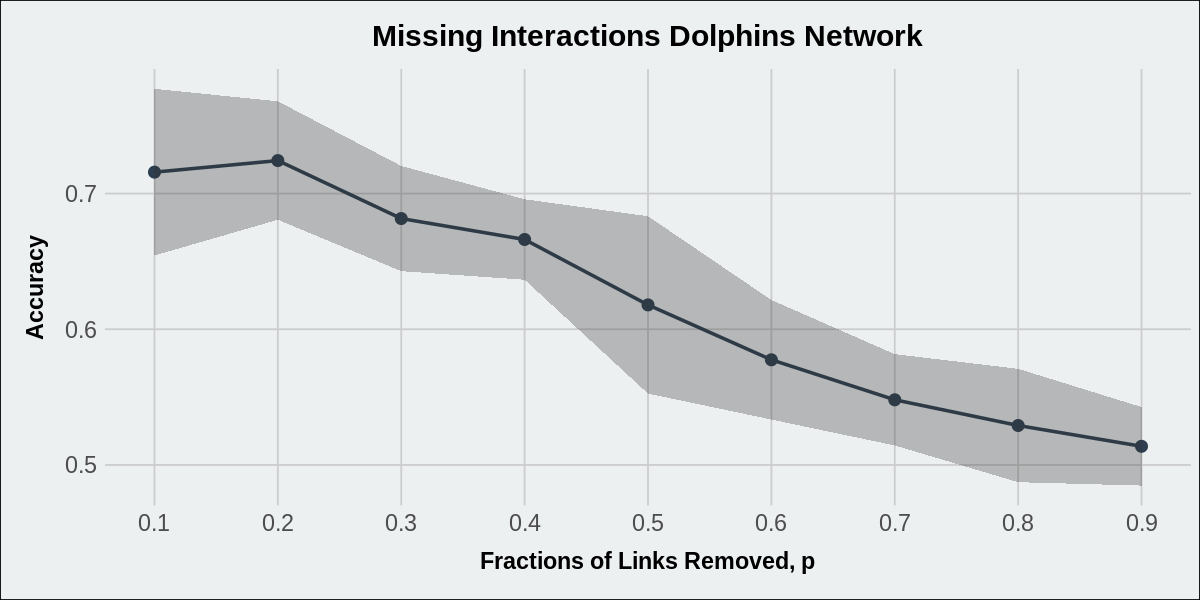

In [30]:
dolphins_missing <- read.csv("./Data/dolphins_missing.csv")

accuracy_plot(dolphins_missing, title="Missing Interactions Dolphins Network",
xlabel="Fractions of Links Removed, p")
